In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

**считываем датасет**

In [294]:
df = pd.read_csv("CC GENERAL.csv")

In [5]:
df.shape

(8950, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [295]:
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(0)

In [296]:
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].value_counts().iloc[0])

видно, что все признаки вещественные

In [4]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [8]:
for column in df.columns:
    print(f'{column}, unqiue: {df[column].nunique()}')

CUST_ID, unqiue: 8950
BALANCE, unqiue: 8871
BALANCE_FREQUENCY, unqiue: 43
PURCHASES, unqiue: 6203
ONEOFF_PURCHASES, unqiue: 4014
INSTALLMENTS_PURCHASES, unqiue: 4452
CASH_ADVANCE, unqiue: 4323
PURCHASES_FREQUENCY, unqiue: 47
ONEOFF_PURCHASES_FREQUENCY, unqiue: 47
PURCHASES_INSTALLMENTS_FREQUENCY, unqiue: 47
CASH_ADVANCE_FREQUENCY, unqiue: 54
CASH_ADVANCE_TRX, unqiue: 65
PURCHASES_TRX, unqiue: 173
CREDIT_LIMIT, unqiue: 205
PAYMENTS, unqiue: 8711
MINIMUM_PAYMENTS, unqiue: 8636
PRC_FULL_PAYMENT, unqiue: 47
TENURE, unqiue: 7


**рассмотрим корреляцию признаков**

по матрице корреляции видно, что присутствуют хорошии корреляции между признаками и потенциальными таргетами

(17, 17)


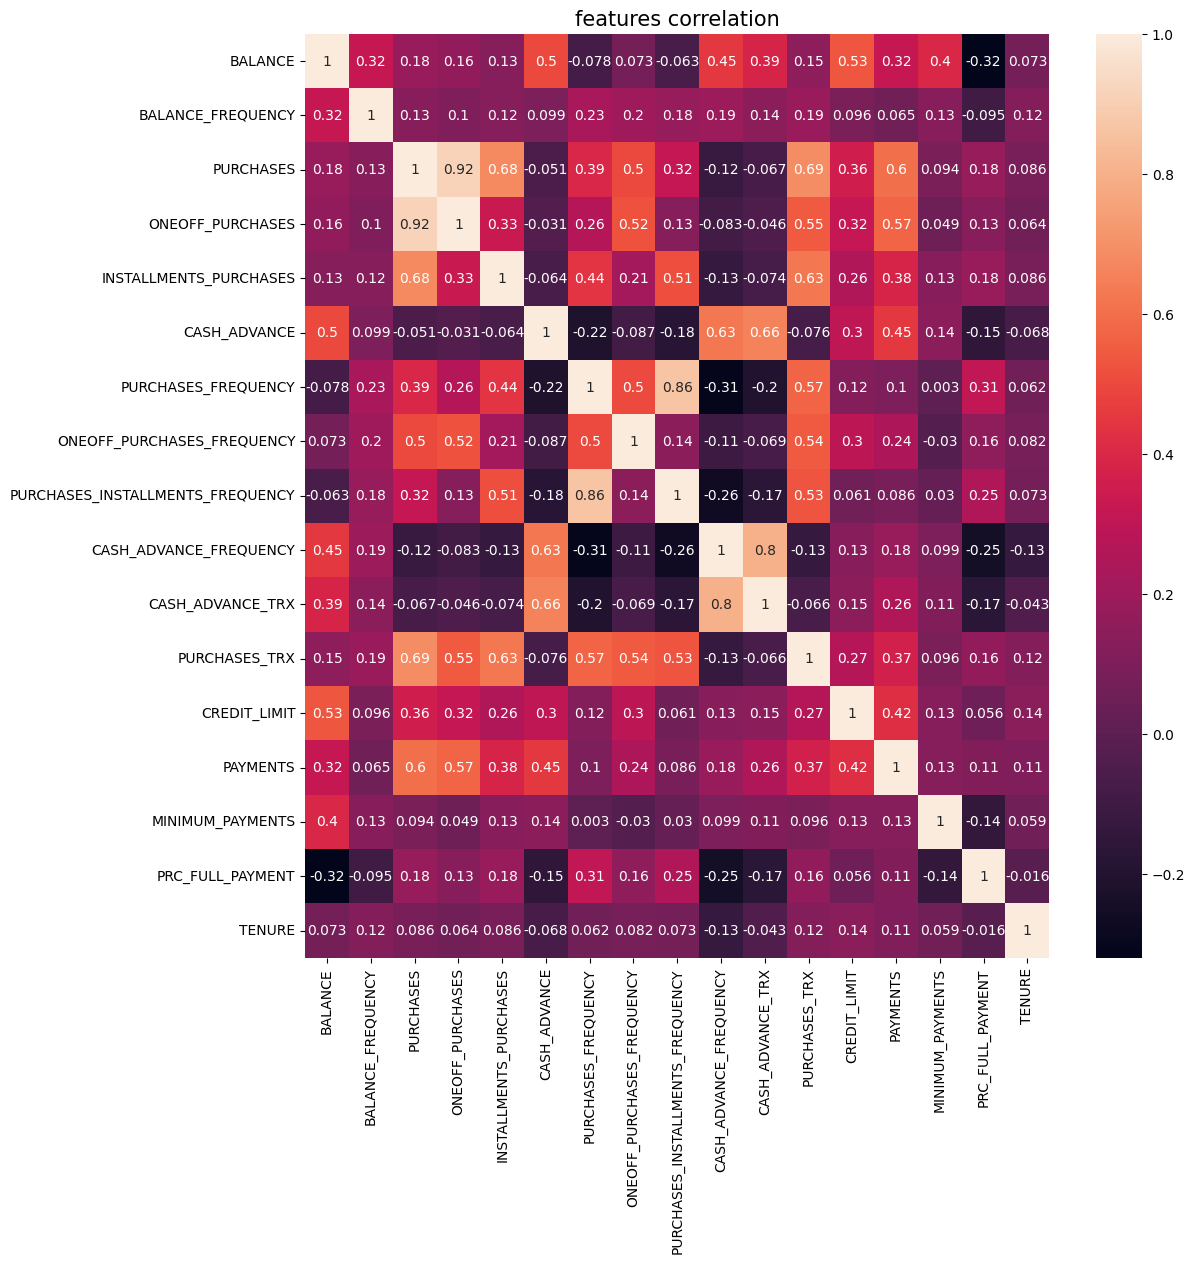

In [15]:
plt.figure(figsize=(12, 12))
plt.title('features correlation', fontsize=15)
corr_matrix = df.drop(['CUST_ID'], axis=1).corr()
print(corr_matrix.shape)
sns.heatmap(corr_matrix, annot=True)
plt.show()

**уберем из признакового пространства id пользователя, так как он не несёт никакой полезной информации**

уберём сильнокоррелирующие колонки - потенциальные дубликаты 

In [34]:
for i, col1 in enumerate(corr_matrix.columns):
    for col2 in corr_matrix.columns[i+1:]:
        correlation = corr_matrix.loc[col1, col2] 
        if np.abs(correlation) > 0.9:
            print(f"{col1}, {col2}: {correlation}")

PURCHASES, ONEOFF_PURCHASES: 0.9168445587151489


In [297]:
df.drop(['CUST_ID', 'ONEOFF_PURCHASES'], axis=1, inplace=True)

**избавимся от выбросов в данных**

1) для начала посмотрим на гистограммы для каждого из признаков
2) отсчечём выбросы по определённому квантилю

Before clipping:


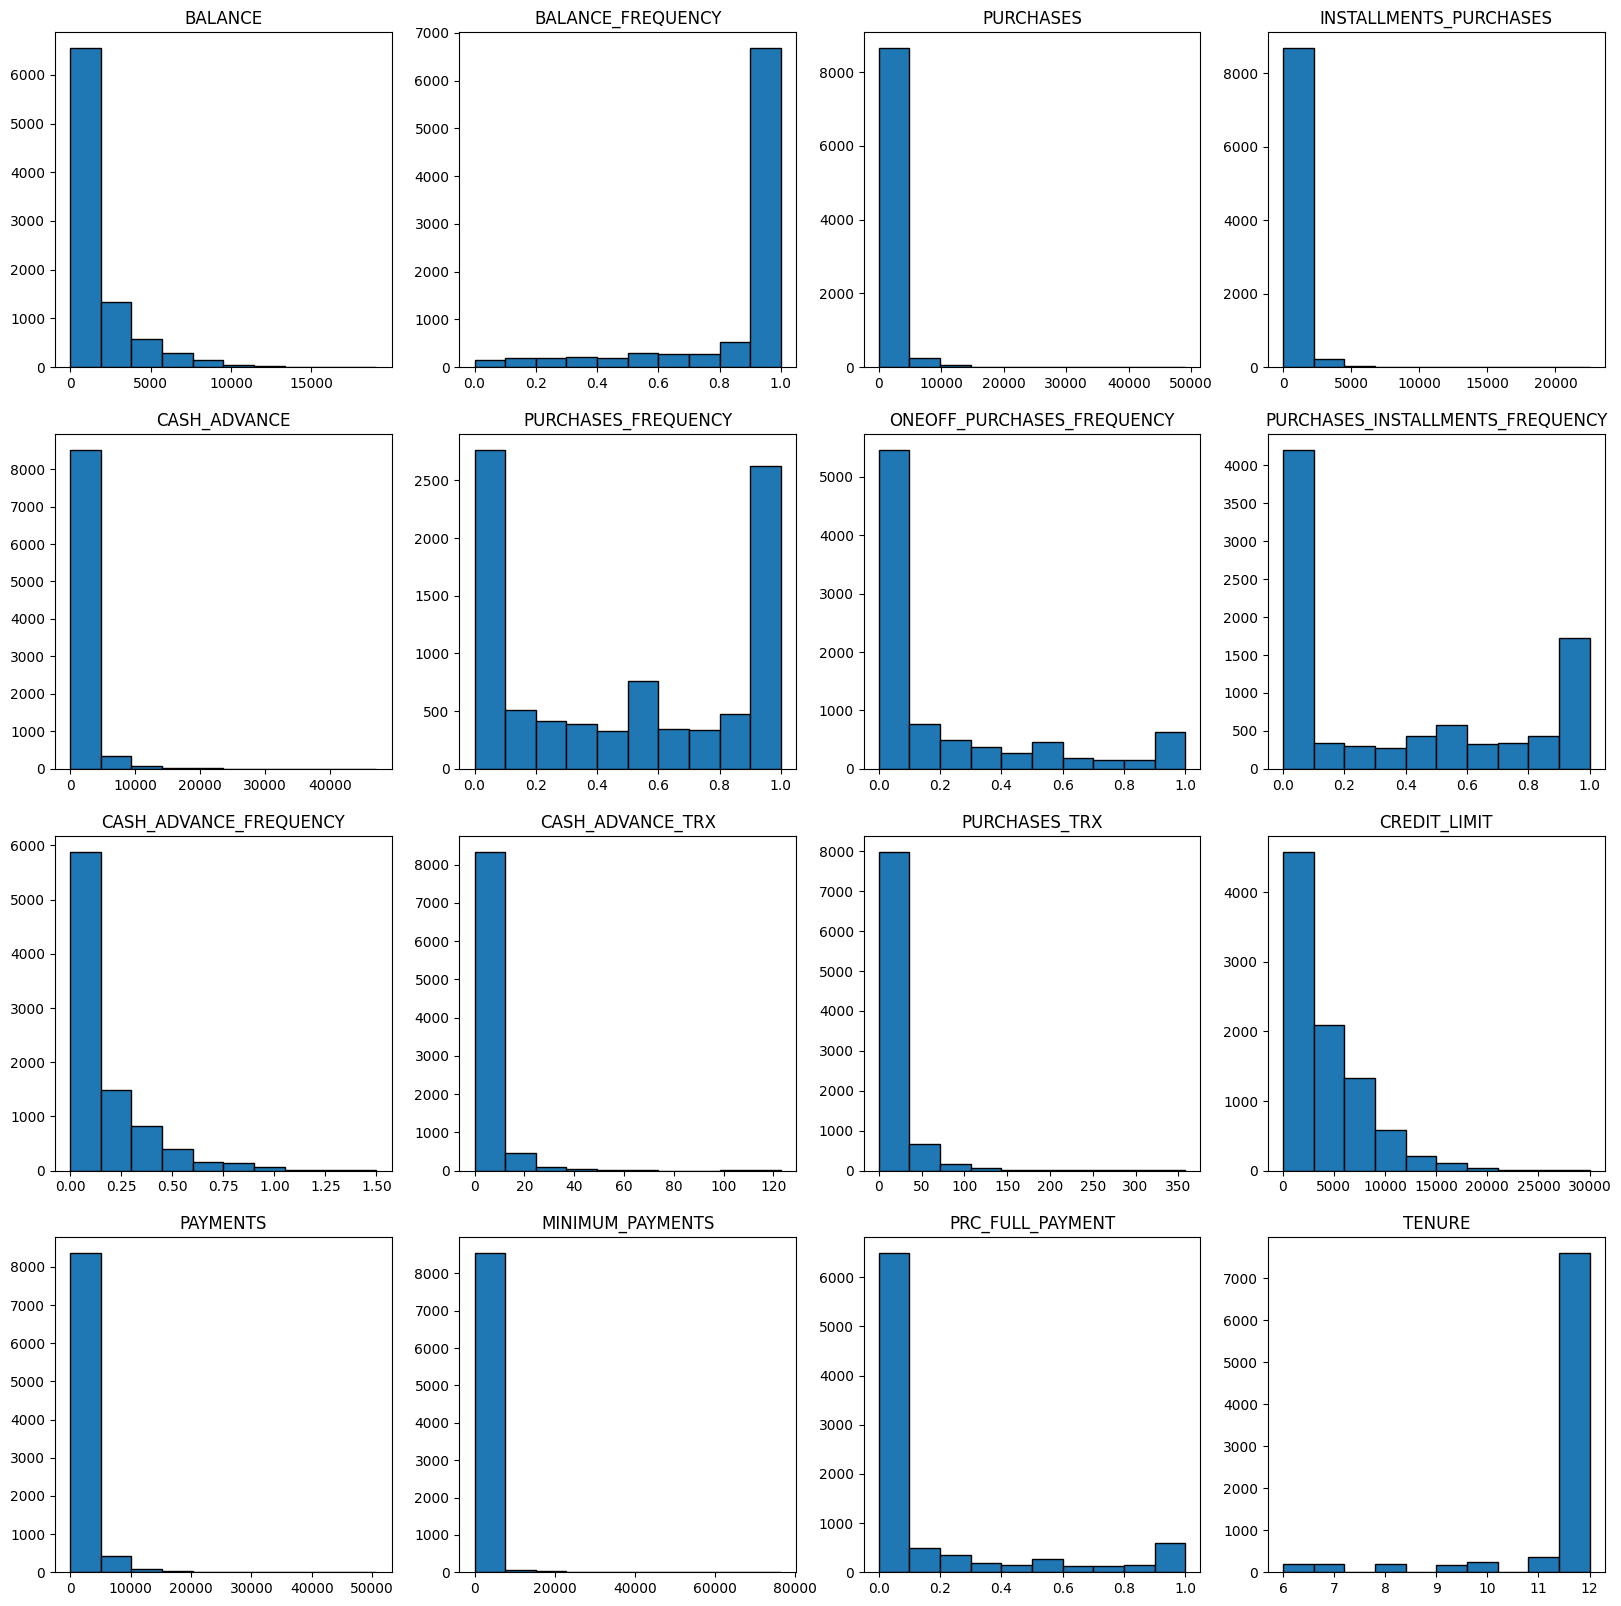

In [63]:
def make_histograms(df):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

    for i in range(4):
        for j in range(4):
            axes[i, j].set_title(f"{df.columns[i*4 + j]}")
            axes[i, j].hist(df.iloc[:, i*4 + j], ec='k')

    plt.show()

print('Before clipping:')
make_histograms(df)

по гистограммам видно, что потенциальные выбросы находятся в колонках, связанных с суммами выплат и финансовыми показателями

In [78]:
columns_to_clip = ['BALANCE', 'PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS']

In [298]:
def clip_columns(df, columns, Q1=0.1, Q3=0.9):
  for col in columns:
    q1_value = np.quantile(df[col].values, Q1)
    q3_value = np.quantile(df[col].values, Q3)
    iqr = q3_value - q1_value
    low_threshold = q1_value - 1.5 * iqr
    up_threshold = q3_value + 1.5 * iqr
    
    df.loc[df[col] < low_threshold, col] = low_threshold
    df.loc[df[col] > up_threshold, col] = up_threshold
    
  return df

df_clipped = clip_columns(df.copy(), columns_to_clip)

After clipping:


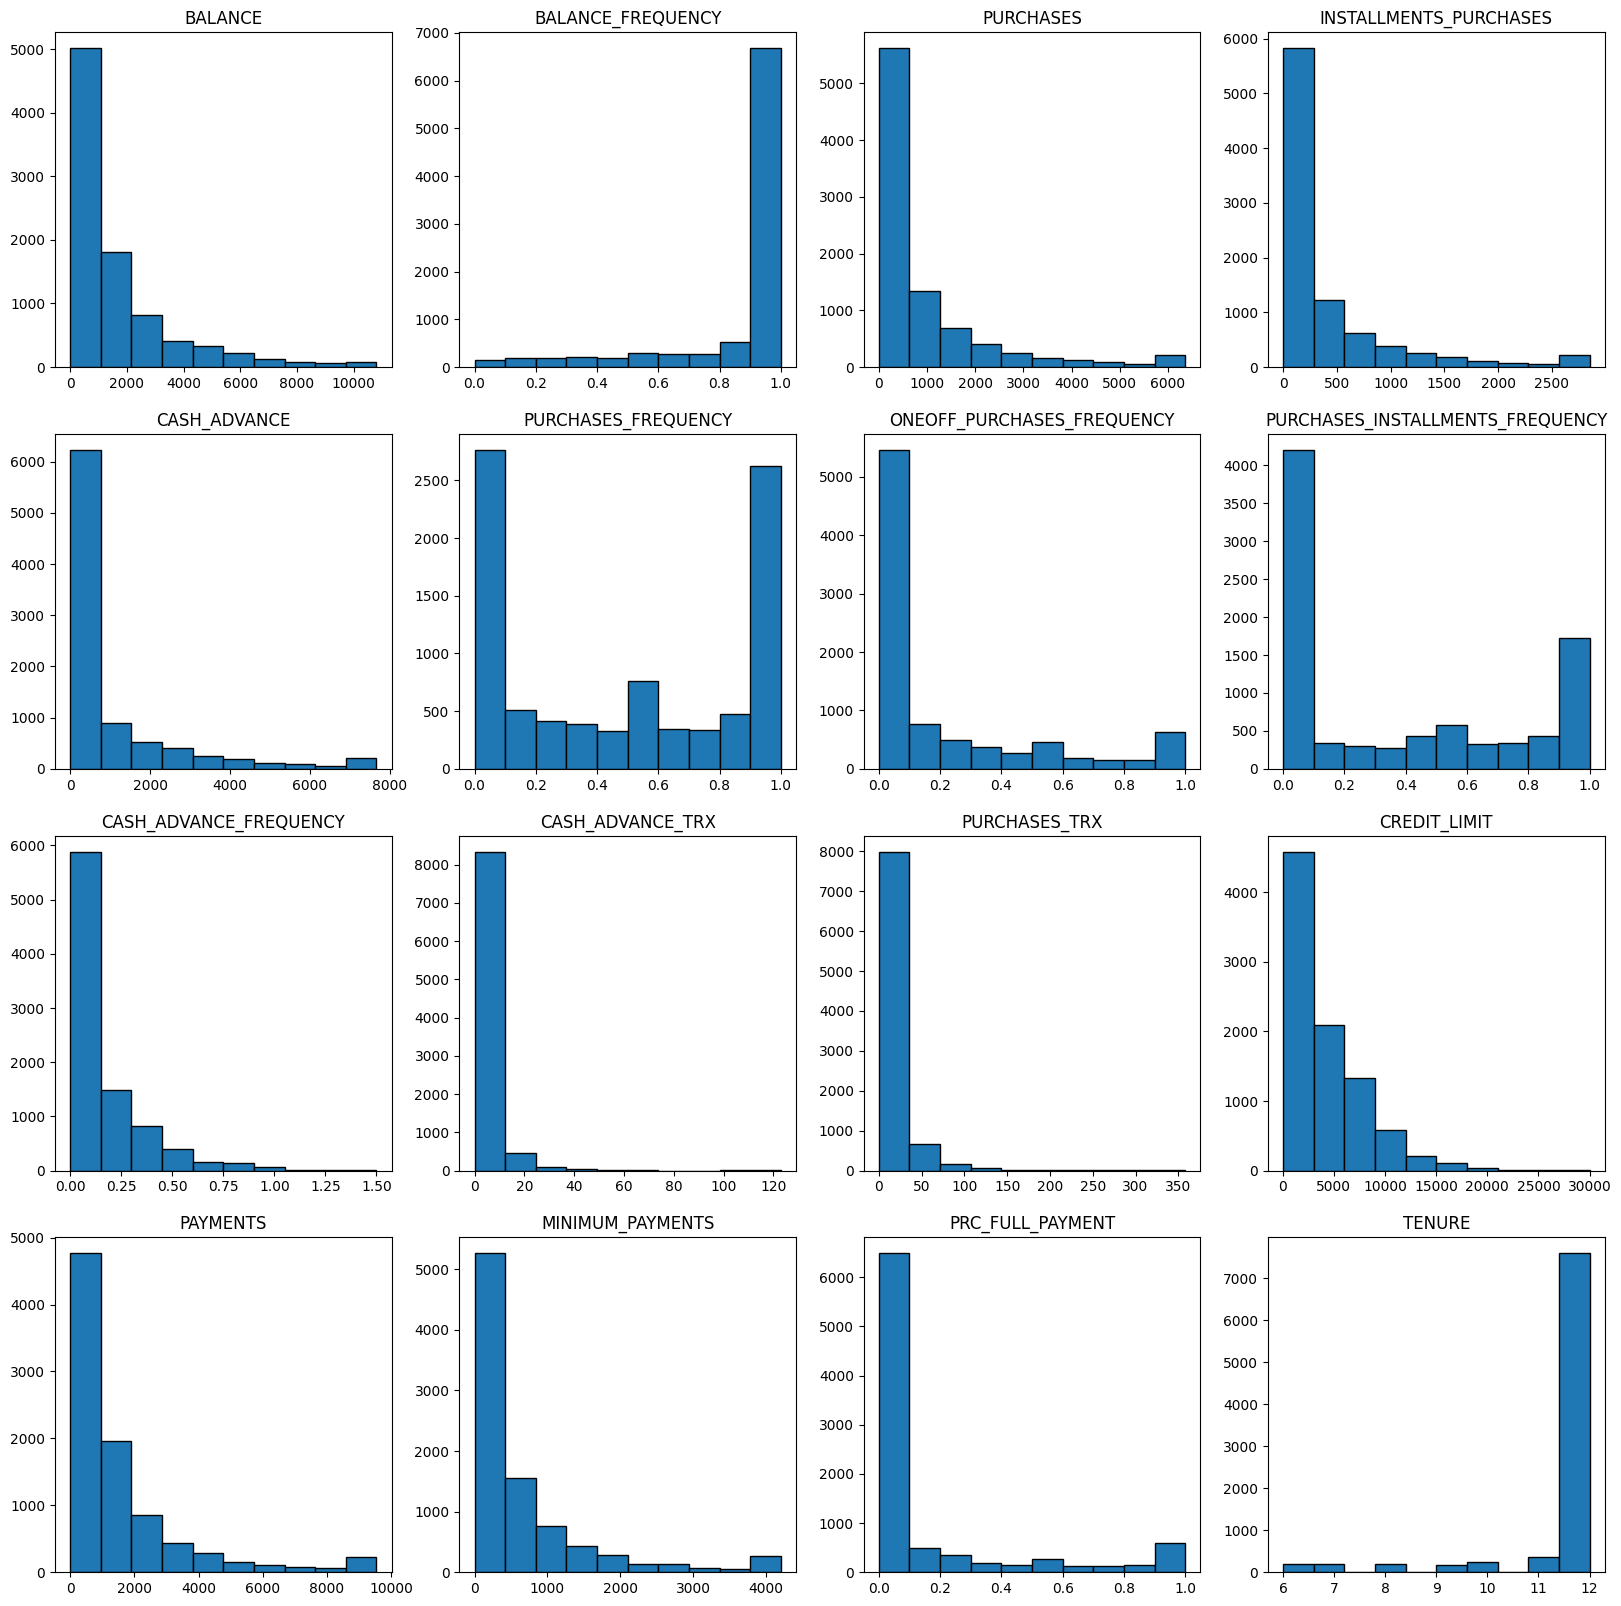

In [299]:
print('After clipping:')
make_histograms(df_clipped)

**поскольку KMEANS - метрический метод кластеризации, для него важна нормировка данных**

воспользуемся Standard Scaler

In [158]:
import warnings
warnings.filterwarnings('ignore')

In [300]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clipped)

попробуем выбрать оптимальное количество кластеров по правилу локтя:

In [160]:
intercluster_distances = []

for n_clusters in range(1, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(df_scaled)
    intercluster_distances.append(kmeans.inertia_)

**по графику затруднительно выбрать оптимальное число кластеров, кажется что оптимальное значение находится в диапазоне 4-5**

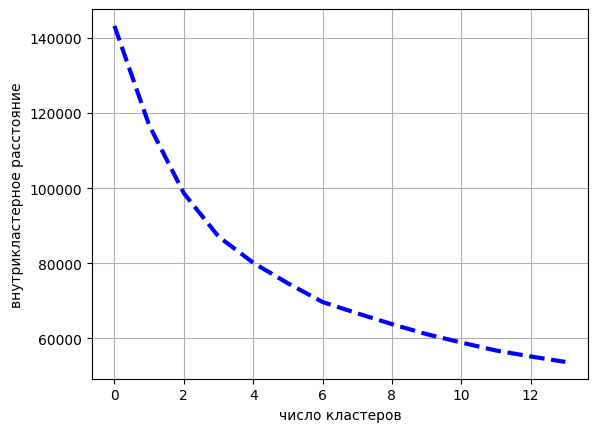

In [161]:
plt.plot(intercluster_distances, '--', lw=3, color='blue')
plt.grid(True)
plt.ylabel('внутрикластерное расстояние')
plt.xlabel('число кластеров')
plt.show()

Воспользуемся метрикой **Average Silhoutte Score** для выбора оптимального числа кластеров

Average silhouette score (средний индекс силуэта) - это обобщенная метрика, используемая для оценки качества кластеризации. Она представляет собой среднее значение индекса силуэта для всех объектов в выборке.

Средний индекс силуэта может принимать значения от -1 до 1, где значение близкое к 1 указывает на хорошую кластеризацию, а значение близкое к -1 указывает на плохую кластеризацию. Значение 0 указывает на то, что объект находится на границе между двумя кластерами.

Для вычисления среднего индекса силуэта для всех объектов в выборке, необходимо вычислить индекс силуэта для каждого объекта и затем найти среднее значение этих индексов.

Средний индекс силуэта может быть использован для выбора оптимального числа кластеров в методе k-средних или других алгоритмах кластеризации. Чем выше значение среднего индекса силуэта, тем лучше кластеризация. Оптимальное число кластеров будет тем, при котором значение среднего индекса силуэта максимально.

In [162]:
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

silhouette_scores = {}

for n_clusters in tqdm(range(2, 15)):
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  labels = kmeans.fit_predict(df_scaled)
  silhouette_scores[n_clusters] = silhouette_score(df_scaled, labels)

  0%|          | 0/13 [00:00<?, ?it/s]

**на графике видно, что оптимальное количество кластеров - 2**

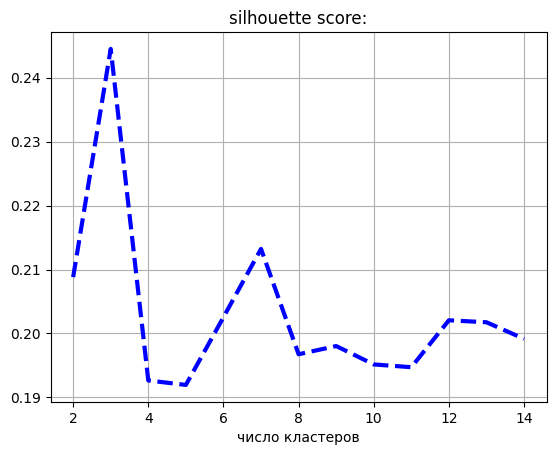

In [170]:
plt.plot(silhouette_scores.keys(), silhouette_scores.values(), '--', lw=3, color='blue')
plt.title('silhouette score:')
plt.grid(True)
plt.xlabel('число кластеров')
plt.show()

# визуализация кластеризации

**Для визуализации кластеризации воспользуемся двумя методами, уменьшающими признаковое пространство**

1) PCA - метод главных компонент
2) t-SNE - стохастическое вложение соседей с t-распределением

In [287]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(df_scaled)
labels = kmeans.predict(df_scaled)

In [288]:
df['cluster'] = labels + 1

видно, что в различных группах значение признака BALANCE сильно разнится, что различает кластеры друг от друга 

In [264]:
df.groupby('cluster').mean().head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,
1,1406.305650,0.948321,2065.812959,912.374102,447.933731,0.908210,0.362010,0.738428,0.058482,1.430582,31.139387,5166.525049,2237.258971,873.934212,0.272209,11.700800
2,1672.048872,0.828948,280.503644,70.119026,1339.972320,0.206156,0.093943,0.110079,0.187284,4.485451,3.535761,4036.660762,1390.285005,806.812137,0.073124,11.392529


**PCA**

In [265]:
from sklearn.decomposition import PCA

In [303]:
df = pd.read_csv("CC GENERAL.csv")
df['cluster'] = labels + 1
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(0)
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].value_counts().iloc[0])

In [290]:
X, Y = df.drop(['cluster', 'CUST_ID', 'ONEOFF_PURCHASES'], axis=1), df['cluster']


def pca_transform(data, targets):
  data = StandardScaler().fit_transform(data)
  pca_embed = pd.DataFrame(data=PCA(n_components=2).fit_transform(data), columns=['feature_1', 'feature_2'])
  
  return pd.concat([pca_embed, pd.DataFrame(targets)], axis=1)

pca_embed = pca_transform(X, Y)

**по графику видно, что количество кластеров 5 - избыточно, оранжевый и красный кластер практически совпадают**

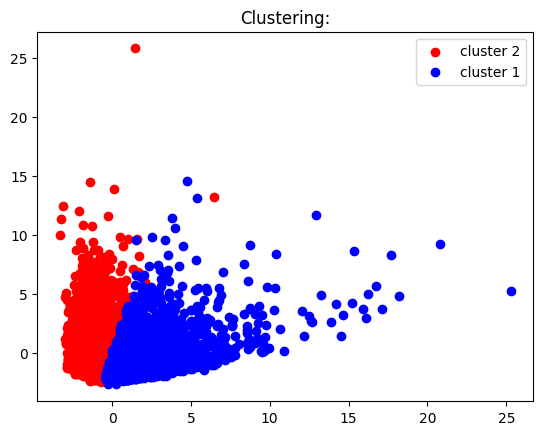

In [291]:
def visualize_clustering(embed):
    clusters = embed['cluster'].unique()
    colors = ['red', 'blue', 'green', 'orange', 'yellow']

    plt.title('Clustering:')
    for cluster, color in zip(clusters, colors):
        points = embed[embed['cluster'] == cluster]
        plt.scatter(points['feature_1'], points['feature_2'], color=color, label=f'cluster {cluster}')
        
    plt.legend()
    plt.show()

visualize_clustering(pca_embed)

**попробуем кластеризацию с 4-мя кластерами**

тут кажется всё кластеризуется как надо

cluster
4    3834
1    3088
3    1241
2     787
Name: count, dtype: int64

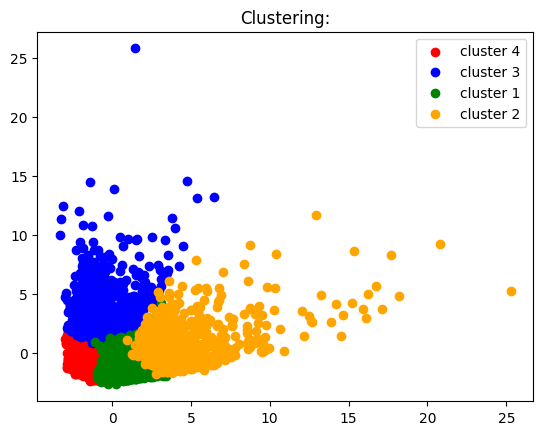

In [283]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(df_scaled)
labels = kmeans.predict(df_scaled)
df['cluster'] = labels + 1

X, Y = df.drop(['cluster', 'CUST_ID', 'ONEOFF_PURCHASES'], axis=1), df['cluster']
display(Y.value_counts())

visualize_clustering(pca_transform(X, Y))

**Попоробуем метод t-SNE**

это более продвинутый метод кластеризации, 

в результате сжатия признакового пространства кластеры тоже выделились достаточно чётко 

In [292]:
from sklearn.manifold import TSNE

def tsne_transform(data, targets):
  data = StandardScaler().fit_transform(data)
  tsne_embed = pd.DataFrame(data=TSNE(n_components=2).fit_transform(data), columns=['feature_1', 'feature_2'])
  
  return pd.concat([tsne_embed, pd.DataFrame(targets)], axis=1)

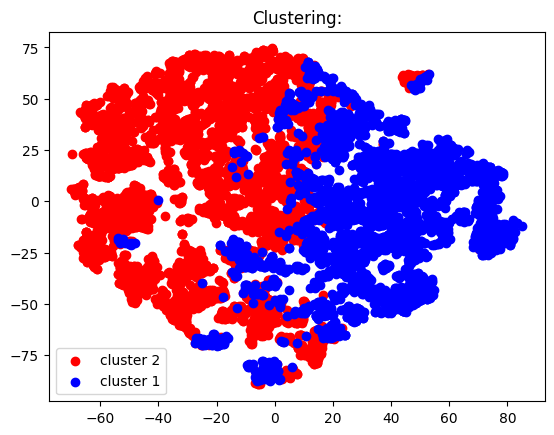

In [293]:
visualize_clustering(tsne_transform(X, Y))

**как влияет выбор начальной точки на качество кластеризации**

для этого запустим метод Kmeans с параметром init = random

видно, что число точек в кластерах разнится (для 4 кластеров), но очень незначительно

при выборе 2 кластеров начальная инициализация вообще никак не влияет на результат кластеризации

cluster
4    3850
1    3091
3    1223
2     786
Name: count, dtype: int64


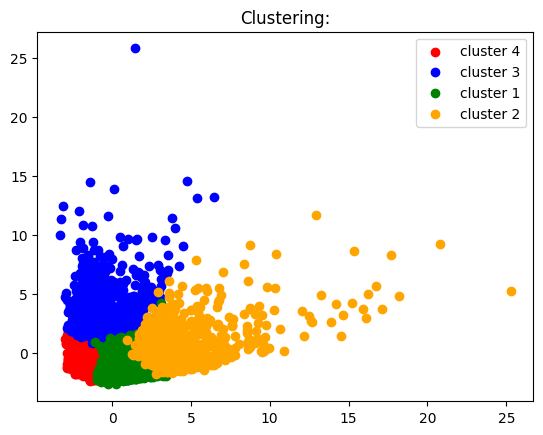

cluster
1    3834
4    3088
2    1241
3     787
Name: count, dtype: int64


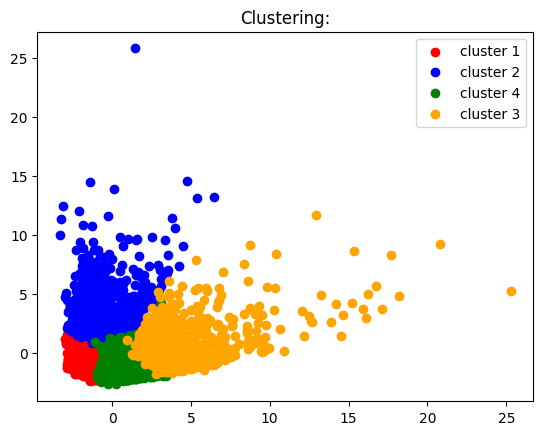

cluster
4    3834
2    3082
3    1241
1     793
Name: count, dtype: int64


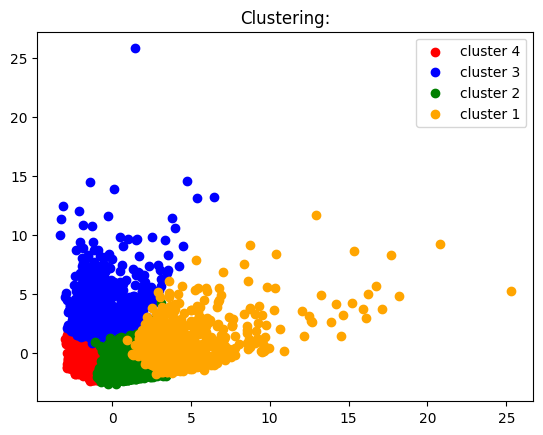

In [309]:
for i in range(3):
    kmeans = KMeans(n_clusters=4, init='random').fit(df_scaled)
    labels = kmeans.predict(df_scaled)
    df['cluster'] = labels + 1
    print(df['cluster'].value_counts())

    X, Y = df.drop(['cluster', 'CUST_ID', 'ONEOFF_PURCHASES'], axis=1), df['cluster']
    visualize_clustering(pca_transform(X, Y))

**иногда может быть так, что метод KMeans не сходится при различных инициализациях центроид, эту проблему решает метод KMeans++** 